# 参考資料

# Environment

## Libraries

In [165]:
import sys

sys.path.append("../")
from calendar import month_name

import lightgbm as lgb
import pandas as pd
import seaborn as sns
from datamart import Datamart
from feature import Feature
from matplotlib import pyplot as plt
from name import Name
from pandas.plotting import register_matplotlib_converters
from raw_data import RawData
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from symbol_data import SymbolData

register_matplotlib_converters()

## Functions & Classes

In [2]:
def create_datamart(
    ticker: str,
    num_lag: int = 5,
    days_before: int = 1,
    single_values: str = "close",
    nation: str = "US",
) -> pd.DataFrame:
    """データマートを生成する。"""
    name = Name(ticker, nation)
    ticker = name.ticker
    symbol_data = SymbolData(ticker).symbol_data
    raw_data = RawData(symbol_data).raw_data
    return Datamart(raw_data, single_values, num_lag, days_before, ticker).datamart

In [188]:
class ModelTimeSeries:
    """Model class predicts future price, up or down.
    Use LightGBM as a predictor model.
    Args:
        datamart: the stock datamart you want to predict
        feature: explanatory variables
    """

    def __init__(self, datamart, feature):
        self._datamart = datamart
        self._feature = feature

    @property
    def _df(self):
        _df = pd.concat([self._datamart, self._feature], axis=1)
        _df.index = pd.to_datetime(_df.index, unit="ms")
        return _df

    @property
    def _X(self):
        # TODO: 予測対象日の株価は特徴量として使用しない
        col = [_col for _col in self._df.columns if "N-0" not in _col]
        col.remove("target")
        return self._df[col]

    @property
    def _y(self):
        return self._df["target"]

    def _train_test_split(self):
        # WARNING: wrong description. Don't use this desc.
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self._X, self._y, test_size=0.3, random_state=0
        )

    def fit(self):
        self._train_test_split()
        self.clf = lgb.LGBMClassifier()
        self.clf.fit(self.X_train, self.y_train)

    def predict(self):
        self.fit()
        self.y_pred = self.clf.predict(self.X_test)
        return self.y_pred

    def cv_time_series(self, data):
        # データの並び順を元に分割する
        folds = TimeSeriesSplit(n_splits=5)
        # 学習用のデータとテスト用のデータに分割するためのインデックス情報を得る
        idx = []
        clfs = []
        f1_scores = []
        for i, (train_index, test_index) in enumerate(folds.split(data)):
            idx.append((train_index, test_index))
            train = data.loc[idx[i][0]]
            test = data.loc[idx[i][1]]
            col = [_col for _col in data.columns if "N-0" not in _col]
            col.remove("target")
            col.remove("timestamp")
            X_train, X_test, y_train, y_test = (
                train[col],
                test[col],
                train["target"],
                test["target"],
            )
            clf = lgb.LGBMClassifier()
            clf.fit(X_train, y_train)
            print(f" Validation {i+1} ".center(50, "-"))
            print("Accuracy Score:", accuracy_score(y_test, clf.predict(X_test)))
            print(
                "Precision Score:",
                precision_score(y_test, clf.predict(X_test), zero_division=0),
            )
            print(
                "Recall Score:",
                recall_score(y_test, clf.predict(X_test), zero_division=0),
            )
            print("F1 Score:", f1_score(y_test, clf.predict(X_test)))
            clfs.append(clf)
            f1_scores.append(f1_score(y_test, clf.predict(X_test)))
        f1_score_max = max(f1_scores)
        idx_max = f1_scores.index(f1_score_max)
        clf_max = clfs[idx_max]
        return clf_max, f1_score_max

# Main

In [66]:
datamart_msft = create_datamart("msft")
datamart_dia = create_datamart("dia")
datamart_spy = create_datamart("spy")

In [67]:
features = Feature([datamart_dia, datamart_spy]).concat_datamarts()

## 誤った予測アルゴリズム

In [189]:
model = ModelTimeSeries(datamart_msft, features)

In [190]:
model.fit()

In [191]:
model.predict()

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0])

In [192]:
# 問題なく予測できているが、下記の通り学習、テストデータに使用しているデータの日時に問題がある。

In [193]:
print("学習データ期間", model.X_train.index.min(), "~", model.X_train.index.max())
print("テストデータ期間", model.X_test.index.min(), model.X_test.index.max())

学習データ期間 2021-01-06 14:30:00 ~ 2022-02-11 14:30:00
テストデータ期間 2021-01-05 14:30:00 2022-02-04 14:30:00


- 学習データはモデル構築に、テストデータは構築されたモデルの妥当性の確認に使用したい。
- 上記の例だと、2022/2/11の株価の値を使用してモデルを構築し、2022/2/4の株価の値を正しく予測できるか確認していることになる。
- 2022/2/4の株価の値を予測する際に使用できるのは、2022/2/3までのデータである。
- TODO: これらを踏まえ、学習データとテストデータの分割方法を現状の_train_test_splitから変更する必要がある。

## 正しいアルゴリズム

In [194]:
# NOTE: まずデータを古い順に並び替える。
data = model._df.sort_index().reset_index()
data.head()

,timestamp,target,msft_close_N-0,msft_close_N-1,msft_close_N-2,msft_close_N-3,msft_close_N-4,msft_close_N-5,dia_close_N-0,dia_close_N-1,dia_close_N-2,dia_close_N-3,dia_close_N-4,dia_close_N-5,spy_close_N-0,spy_close_N-1,spy_close_N-2,spy_close_N-3,spy_close_N-4,spy_close_N-5
0,2021-01-05 14:30:00,1,217.899994,217.690002,222.419998,221.679993,224.149994,224.960007,303.839996,302.320007,305.790009,304.130005,303.459991,304.000000,371.329987,368.790009,373.880005,371.989990,371.459991,372.170013
1,2021-01-06 14:30:00,0,212.250000,217.899994,217.690002,222.419998,221.679993,224.149994,308.209991,303.839996,302.320007,305.790009,304.130005,303.459991,373.549988,371.329987,368.790009,373.880005,371.989990,371.459991
2,2021-01-07 14:30:00,1,218.289993,212.250000,217.899994,217.690002,222.419998,221.679993,310.500000,308.209991,303.839996,302.320007,305.790009,304.130005,379.100006,373.549988,371.329987,368.790009,373.880005,371.989990
3,2021-01-08 14:30:00,1,219.619995,218.289993,212.250000,217.899994,217.690002,222.419998,311.040009,310.500000,308.209991,303.839996,302.320007,305.790009,381.260010,379.100006,373.549988,371.329987,368.790009,373.880005
4,2021-01-11 14:30:00,0,217.490005,219.619995,218.289993,212.250000,217.899994,217.690002,310.170013,311.040009,310.500000,308.209991,303.839996,302.320007,378.690002,381.260010,379.100006,373.549988,371.329987,368.790009


In [195]:
# NOTE: 日時を表す列名、予測対象日の株価の列名を定義する。
date_time = "timestamp"
target = "msft_close_N-0"

index of train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
index of test: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
----------
index of train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
index of test: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141]
----------
index of train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  3

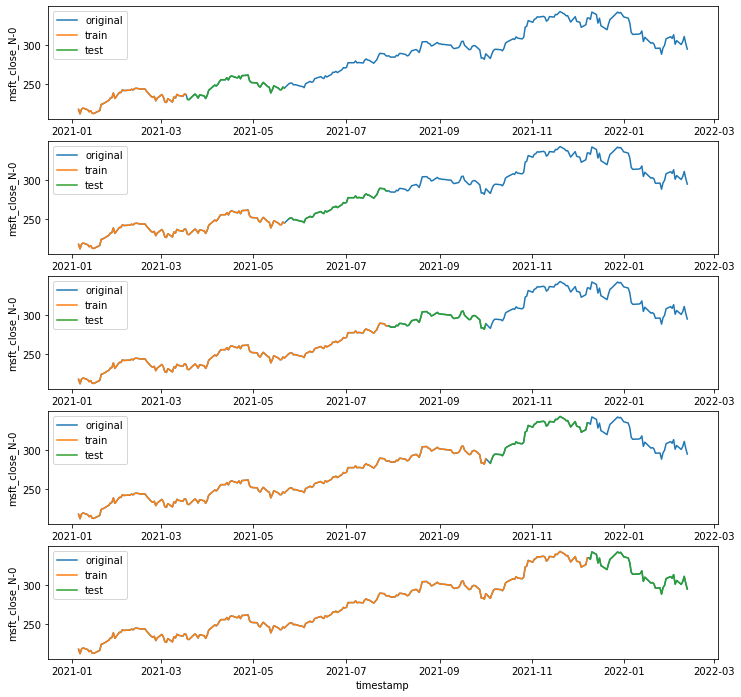

In [196]:
# NOTE: データセットの分割方法としては、このセルを実行することで表示される5パターンなどが望ましい。


def viz_train_test(data: pd.DataFrame, date_time: str, target: str):
    # データの並び順を元に分割する
    folds = TimeSeriesSplit(n_splits=5)

    # 5 枚のグラフを用意する
    fig, axes = plt.subplots(5, 1, figsize=(12, 12))

    # 学習用のデータとテスト用のデータに分割するためのインデックス情報を得る
    for i, (train_index, test_index) in enumerate(folds.split(data)):
        # 生のインデックス
        print(f"index of train: {train_index}")
        print(f"index of test: {test_index}")
        print("----------")
        # 元のデータを描く
        sns.lineplot(data=data, x=date_time, y=target, ax=axes[i], label="original")
        # 学習用データを描く
        sns.lineplot(
            data=data.iloc[train_index],
            x=date_time,
            y=target,
            ax=axes[i],
            label="train",
        )
        # テスト用データを描く
        sns.lineplot(
            data=data.iloc[test_index],
            x=date_time,
            y=target,
            ax=axes[i],
            label="test",
        )

    # グラフを表示する
    plt.legend()
    plt.show()


viz_train_test(data, date_time, target)

In [197]:
model.cv_time_series(data)

------------------ Validation 1 ------------------
Accuracy Score: 0.5434782608695652
Precision Score: 0.75
Recall Score: 0.13043478260869565
F1 Score: 0.22222222222222218
------------------ Validation 2 ------------------
Accuracy Score: 0.43478260869565216
Precision Score: 0.0
Recall Score: 0.0
F1 Score: 0.0
------------------ Validation 3 ------------------
Accuracy Score: 0.5217391304347826
Precision Score: 0.5
Recall Score: 0.18181818181818182
F1 Score: 0.26666666666666666
------------------ Validation 4 ------------------
Accuracy Score: 0.45652173913043476
Precision Score: 0.6
Recall Score: 0.11538461538461539
F1 Score: 0.1935483870967742
------------------ Validation 5 ------------------
Accuracy Score: 0.43478260869565216
Precision Score: 0.4594594594594595
Recall Score: 0.7391304347826086
F1 Score: 0.5666666666666667


(LGBMClassifier(), 0.5666666666666667)